In [ ]:
pip install tensorflow

In [ ]:
pip install tensorflow-gpu

     |████████████████████████████████| 394.7MB 41kB/s 


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn



In [ ]:
from sklearn.datasets import load_iris

In [ ]:
data = load_iris()
data

{'DESCR': '.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ===========

In [ ]:
feature_df = pd.DataFrame(data['data'], columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
feature_df.head(2)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


In [ ]:
target_series = pd.Series(data['target'], name="Species")
target_series.head(2)

0    0
1    0
Name: Species, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(feature_df, target_series, test_size=0.2, shuffle=True)

create tensorflow input function, and create the models feature columns objects

In [ ]:
def input_function(feature_df, target, batch_size=32):
  data = tf.data.Dataset.from_tensor_slices((dict(feature_df), target))
  return data.batch(batch_size)


In [ ]:
feature_cols = []
for key in x_train.keys():
  feature_cols.append(tf.feature_column.numeric_column(key=key))
feature_cols

[NumericColumn(key='sepal_length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='sepal_width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='petal_length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='petal_width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

Instantiate a classifier model. Staring with Deep Neural network DNNClassifier, specify the layers and the number of classes

In [ ]:
model = tf.estimator.DNNClassifier(feature_columns=feature_cols, hidden_units = [30, 10], n_classes = 3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp6qeasqsa', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Training the model requires an input function, the input function currently returns an object, so we use a lambda function to substitute, and hand it to the input_fn arg in the model

In [ ]:
model.train(input_fn=lambda:input_function(x_train, y_train), steps=5000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp6qeasqsa/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 2.1950552, step = 0
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4...
INFO:tensorflow:Saving checkpoints for 4 into /tmp/tmp6qeasqsa/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4...
INF

Test the model. The model returns a dict with accuracy as its first element so we can index it out

In [ ]:
eval = model.evaluate(input_fn=lambda:input_function(x_test, y_test))
accuracy = eval['accuracy']*100
print(f"Model Accuracy: {accuracy:.2f}%")


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-29T03:41:18Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6qeasqsa/model.ckpt-4
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.19180s
INFO:tensorflow:Finished evaluation at 2020-12-29-03:41:18
INFO:tensorflow:Saving dict for global step 4: accuracy = 0.46666667, average_loss = 1.516613, global_step = 4, loss = 1.516613
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4: /tmp/tmp6qeasqsa/model.ckpt-4
Model Accuracy: 46.67%


Use the model to predict. Then measure the accuracy again. We will use the testing data and use sklearns shuffle to shuffle the data, and reset the index values, then separate the target variable. 

In [ ]:
pred_df = pd.concat([x_test, y_test], axis=1)
from sklearn.utils import shuffle
shuffled = shuffle(pred_df)
shuffled.reset_index(drop=True, inplace=True)
shuffled.head()

,sepal_length,sepal_width,petal_length,petal_width,Species
0,5.0,3.3,1.4,0.2,0
1,5.7,4.4,1.5,0.4,0
2,5.0,3.6,1.4,0.2,0
3,4.7,3.2,1.6,0.2,0
4,6.7,3.0,5.0,1.7,1


In [ ]:
y_pred = shuffled.pop("Species")
x_pred = shuffled

In [ ]:
x_pred.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.0,3.3,1.4,0.2
1,5.7,4.4,1.5,0.4
2,5.0,3.6,1.4,0.2
3,4.7,3.2,1.6,0.2
4,6.7,3.0,5.0,1.7


Now to use the model to predict, using model.predict(input_fn), and passing only the feature data. We still have to use an input function, but we have to change it to take only feature data. Then we will use a lamda function again to pass the function to the model.

In [ ]:
def pred_function(pred_df, batch_size=32):
  features = tf.data.Dataset.from_tensor_slices(dict(pred_df))
  return features.batch(batch_size)

pred_list = []

predictions = model.predict(input_fn=lambda:pred_function(x_pred))
for pred_dict in predictions:
  pred = pred_dict['class_ids'][0]
  pred_list.append(pred)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6qeasqsa/model.ckpt-4
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Compare the output to the known values and get the accuracy

In [ ]:
acc_counter = 0
total_preds = len(y_pred)
for index, pred in enumerate(pred_list):
  if pred == y_pred[index]:
    acc_counter += 1

moedl_acc = acc_counter/total_preds*100
print(f"Model Prediction Accuracy: {moedl_acc:.0f}%")



Model Prediction Accuracy: 47%


This model sucks. We can investigate the predictions.

In [ ]:
pred_list

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

This shows the model only predicts a single class, and the accuracy is that hig because 1) there is only 3 classes to pick from so randomly the accuracy would be 33% 2) the shuffling of the data can randomly permute more of one class in the prediction dataset. In this instance it turns out the proportion of classes that were picked by the model, were randomly highly represented in the prediction dataset. Again we can check this.

In [ ]:
y_pred.value_counts()

0    14
1    10
2     6
Name: Species, dtype: int64

Lets look at training a different Classifier K nearest neighbours in sklearn

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

scale data so particular attributes don't skew the results

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

Instantiate and train the model

In [ ]:
neighbors_model = KNeighborsClassifier(n_neighbors=5)
neighbors_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Use the trained model to predict the testing values and compare accuracy

In [ ]:
knn_results = neighbors_model.predict(X_test)
knn_results

array([1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0,
       0, 0, 1, 2, 0, 0, 0, 1])

In [ ]:
k_pred_score = 0
total_num = len(y_test)

for index, item in enumerate(knn_results):
  if item == y_test.iloc[index]:
    k_pred_score += 1

knn_accuracy = k_pred_score/total_num*100
print(f"K Nearest Neighbors (n = 5) Accuracy : {knn_accuracy:.0f}%")
    

K Nearest Neighbors (n = 5) Accuracy : 87%


So of course KNearest Neighbours is a much better classifier. Next we can try K Means clustering. KMeans is unsupervised (requires no training target values) as it predicts cluster identity based soley on position relative to optimised cluster centroid.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=3)

In [ ]:
kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Visualise the data

In [ ]:
import seaborn as sns
colors = ["red", "blue", "green"]
sns.set_palette(sns.color_palette(colors))

In [ ]:
full_data = pd.concat([feature_df, target_series], axis=1)
full_data.head(2)

,sepal_length,sepal_width,petal_length,petal_width,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0


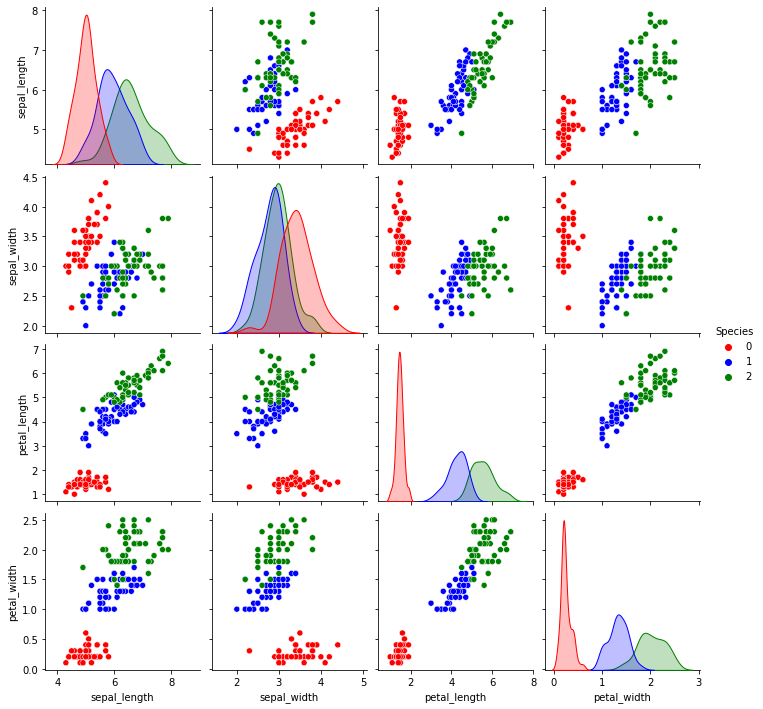

In [ ]:
sns.pairplot(full_data, hue="Species", palette=colors)

kmeans has an attribute .cluster_centers that returns the coordinates of the optimised cluster centers

In [ ]:
kmeans.cluster_centers_

array([[-0.03221535, -0.83573906,  0.31974213,  0.24969239],
       [-1.09981471,  0.87251747, -1.40409591, -1.34346275],
       [ 1.1110122 ,  0.21267856,  0.95998846,  0.98997613]])

validate the model by running the test data, and comparing to known values

In [ ]:
means_results = kmeans.predict(X_test)
means_results

array([0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 2, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1,
       1, 1, 2, 2, 1, 1, 1, 0], dtype=int32)

In [ ]:
means_counter = 0
for index, item in enumerate(means_results):
  if item == y_test.iloc[index]:
    means_counter += 1

num = len(y_test)
means_acc = means_counter/num*100
print(f"KMeans Classifier Accuracy : {means_acc:.0f}%")

KMeans Classifier Accuracy : 10%


KMeans over all dimensions doesnt look too good. We can reduce the dimensions. From the pairplot, we can see that petal width vs petal length provides good separation. We can reduce the feature set to include only these two variables, and then retrain the model

In [ ]:
#create function to calculate any accuracy 
def accuracy_calc(prediction_vals, known_vals, test="" ):
  means_counter = 0
  for index, item in enumerate(prediction_vals):
    if item == known_vals.iloc[index]:
      means_counter += 1

  num = len(y_test)
  acc = means_counter/num*100
  print(f"{test} Accuracy : {acc:.0f}%")

In [ ]:
petal_df = feature_df[['petal_width', 'petal_length']]
petal_df.head(2)

,petal_width,petal_length
0,0.2,1.4
1,0.2,1.4


In [ ]:
petal_means = KMeans(n_clusters=3)

In [ ]:
petal_means.fit(petal_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

We can manually visualise the data and the cluster centroid position, in 2 dimensions.

In [ ]:
clusters = petal_means.cluster_centers_
clusters

array([[0.246     , 1.462     ],
       [2.0375    , 5.59583333],
       [1.34230769, 4.26923077]])

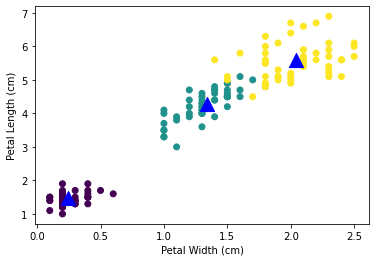

In [ ]:
plt.scatter(petal_df.iloc[:, 0], petal_df.iloc[:, 1], c=target_series)
plt.scatter(clusters[0][0], clusters[0][1], c='blue', s=200, marker = "^")
plt.scatter(clusters[1][0], clusters[1][1], c='blue', s=200, marker = "^")
plt.scatter(clusters[2][0], clusters[2][1], c='blue', s=200, marker = "^")
plt.xlabel('Petal Width (cm)')
plt.ylabel('Petal Length (cm)')
plt.show()

It looks probable. So now predicting again and validating the model

In [ ]:
petal_test = x_pred[["petal_width", "petal_length"]]
petal_test

,petal_width,petal_length
0,0.2,1.4
1,0.4,1.5
2,0.2,1.4
3,0.2,1.6
4,1.7,5.0
5,1.2,4.4
6,2.3,5.9
7,0.2,1.7
8,1.8,4.8
9,1.5,5.0


In [ ]:
petal_preds = petal_means.predict(petal_test)
petal_preds

array([0, 0, 0, 0, 1, 2, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1,
       0, 0, 0, 1, 2, 0, 2, 0], dtype=int32)

In [ ]:
accuracy_calc(petal_preds, y_pred, test="KMeans")

KMeans Accuracy : 60%
